In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from sparrow import Protein
import protfasta


In [2]:
from finches import Mpipi_frontend, CALVADOS_frontend

In [3]:
from shephard.apis import uniprot
from shephard.interfaces import si_domains, si_protein_attributes

In [4]:
HP = uniprot.uniprot_fasta_to_proteome('../../data/human_proteome_clean.fasta')

mode = 'calvados'

if mode == 'mpipi':
    si_domains.add_domains_from_file(HP, '../../data/shprd_IDR_domains_with_atts_tc_eps.tsv')
    xf = Mpipi_frontend()
    
elif mode == 'calvados':
    si_domains.add_domains_from_file(HP, '../../data/shprd_IDR_domains_with_atts_tc_eps_CALVADOS.tsv')
    xf =  CALVADOS_frontend()
else:
    raise Exception('mode must be mpipi or calvados')

# cast to floats
for d in HP.domains:

    # NB calvados critical temperatures are labelled as critical_temperature_mpipi as well :-( 
    d.add_attribute('critical_temperature_mpipi', float(d.attribute('critical_temperature_mpipi')), safe=False)
    d.add_attribute('eps', float(d.attribute('eps')), safe=False)

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [5]:
all_idrs = []
for d in HP.domains:
    if len(d) > 100:
        all_idrs.append(d)
sorted_idrs = sorted(all_idrs, key=lambda domain: domain.attribute('eps'))
sorted_eps = [d.attribute('eps') for d in sorted_idrs]   
sorted_tc = [d.attribute('critical_temperature_mpipi') for d in sorted_idrs]   
sorted_lengths = [len(d) for d in sorted_idrs]   
print(len(sorted_lengths))

9909


On mode calvados found 1460 homotypically attractive IDRs...


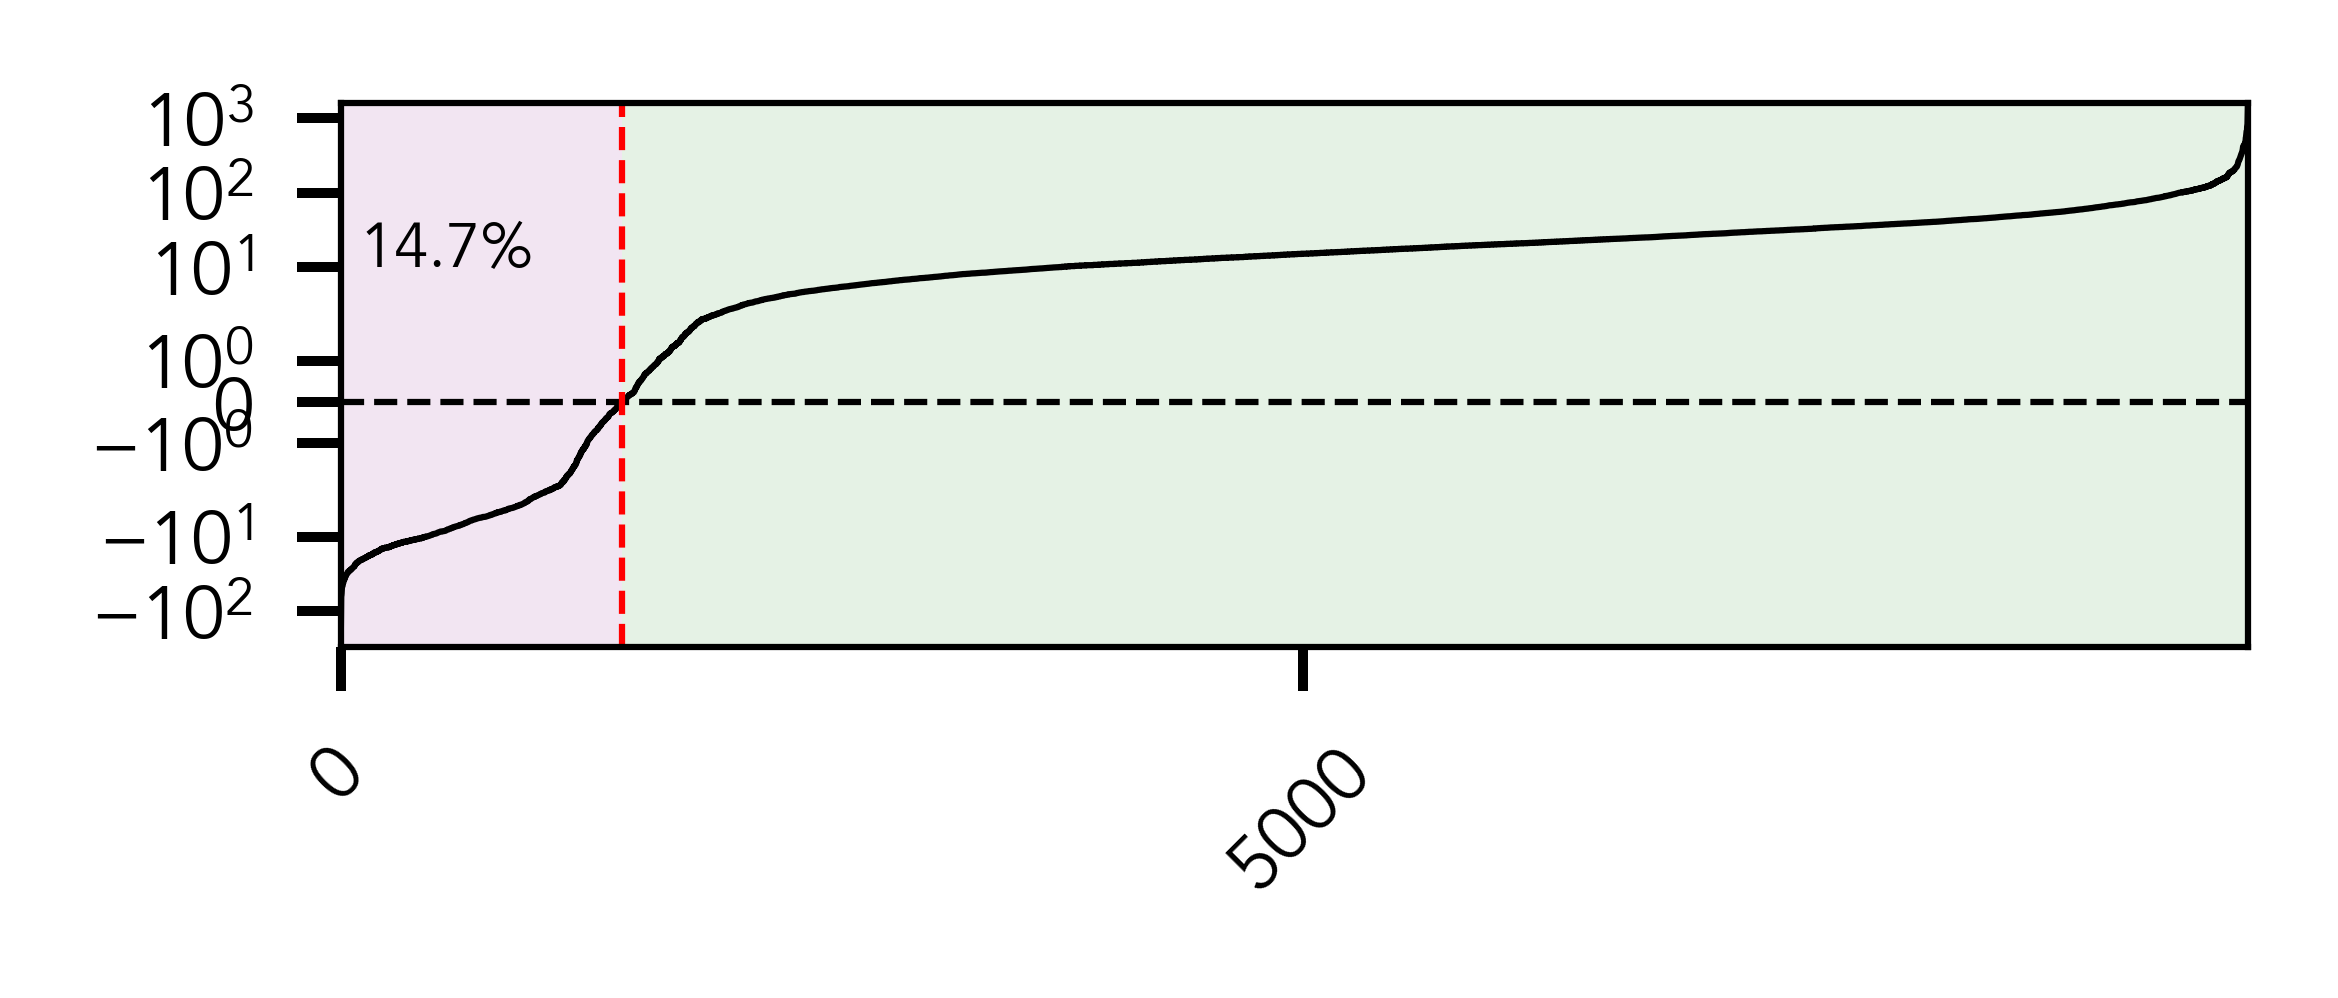

In [6]:
fig = plt.figure(figsize=(2.7, 1.2), dpi=450)
ax = plt.gca()
attractive_eps_count = np.sum(np.array(sorted_eps) < 0)
maxcount=len(sorted_eps)+1

print(f"On mode {mode} found {attractive_eps_count} homotypically attractive IDRs...")
idx_vals = np.arange(1, len(sorted_eps)+1)[0:maxcount]
data_vals = np.array(sorted_eps[0:maxcount])

plt.plot(idx_vals, data_vals, lw=0.5, color='k')
ax.axhline(0, color='k',lw=0.5, ls='--')
ax.axvline(attractive_eps_count, color='r',lw=0.5, ls='--')

plt.xlim(0,maxcount)

tick_locations = np.arange(0, maxcount, 5000)  # Start, stop, step

plt.xticks(tick_locations, fontsize=6, rotation=45, ha='center', va='top')
#plt.ylim([-100,0])
plt.yscale('symlog')

plt.yticks(fontsize=6)
percent_attractive = 100*attractive_eps_count/maxcount
plt.text(100, 10, str(round(percent_attractive,1)) + "%", fontsize=5)
ax.axvspan(0,attractive_eps_count,color='purple', alpha=0.1, lw=0)
ax.axvspan(attractive_eps_count,maxcount, color='green', alpha=0.1, lw=0)
plt.tight_layout()
plt.savefig(f'out_figures/idrome_homotypic_{mode}.pdf')


In [7]:
with open(f'../../data/outdata/proteome_wide_condensate/all_idrs_homotypic_eps_ranked_{mode}.csv','w') as fh:
    fh.write(f"UniProt ID, name, IDR start, IDR end, IDR len, epsilon, sequence\n")
    for d in sorted_idrs:
        safename = d.protein.name.replace(',',';')
        fh.write(f"{d.protein.unique_ID}, {safename}, {d.start}, {d.end}, {len(d)}, {d.attribute('eps')}, {d.sequence}\n")

## Copy number
Analysis of cn vs. epsilon...

In [8]:
si_protein_attributes.add_protein_attributes_from_file(HP,'../../data/shprd_protein_attributes_concentrations.tsv')
                                                      

In [9]:
domains = []
conc = []
eps = []
sizes = []
names = []
for d in HP.domains:
    if 'copy_number' in d.protein.attributes and  len(d)> 50:
        domains.append(d)
        conc.append(int(d.protein.attribute('copy_number')))
        eps.append(d.attribute('eps'))
        sizes.append(len(d))
        names.append(d.protein.unique_ID)

# scale by 5% to make sizes manageable for plotting
sizes = np.array(sizes)*0.05
        

In [10]:
conc_sorted = np.array(sorted(conc))

In [11]:
high_copy_thresh = 284000

# calculate what % of proteins the high_copy_thresh copy number is above
percentile_cn = round(100*np.sum(conc_sorted > 284000)/len(conc_sorted),2)

print(f"High copy thresh of {high_copy_thresh} means we're looking at the top  {percentile_cn}% of expressed proteins")

High copy thresh of 284000 means we're looking at the top  10.0% of expressed proteins


In [12]:
eps_sorted = sorted(eps)

In [13]:
eps_attractive_thresh = eps_sorted[0:int(len(eps_sorted)*0.08)][-1]
eps_repilsive_thresh = eps_sorted[0:int(len(eps_sorted)*0.92)][-1]


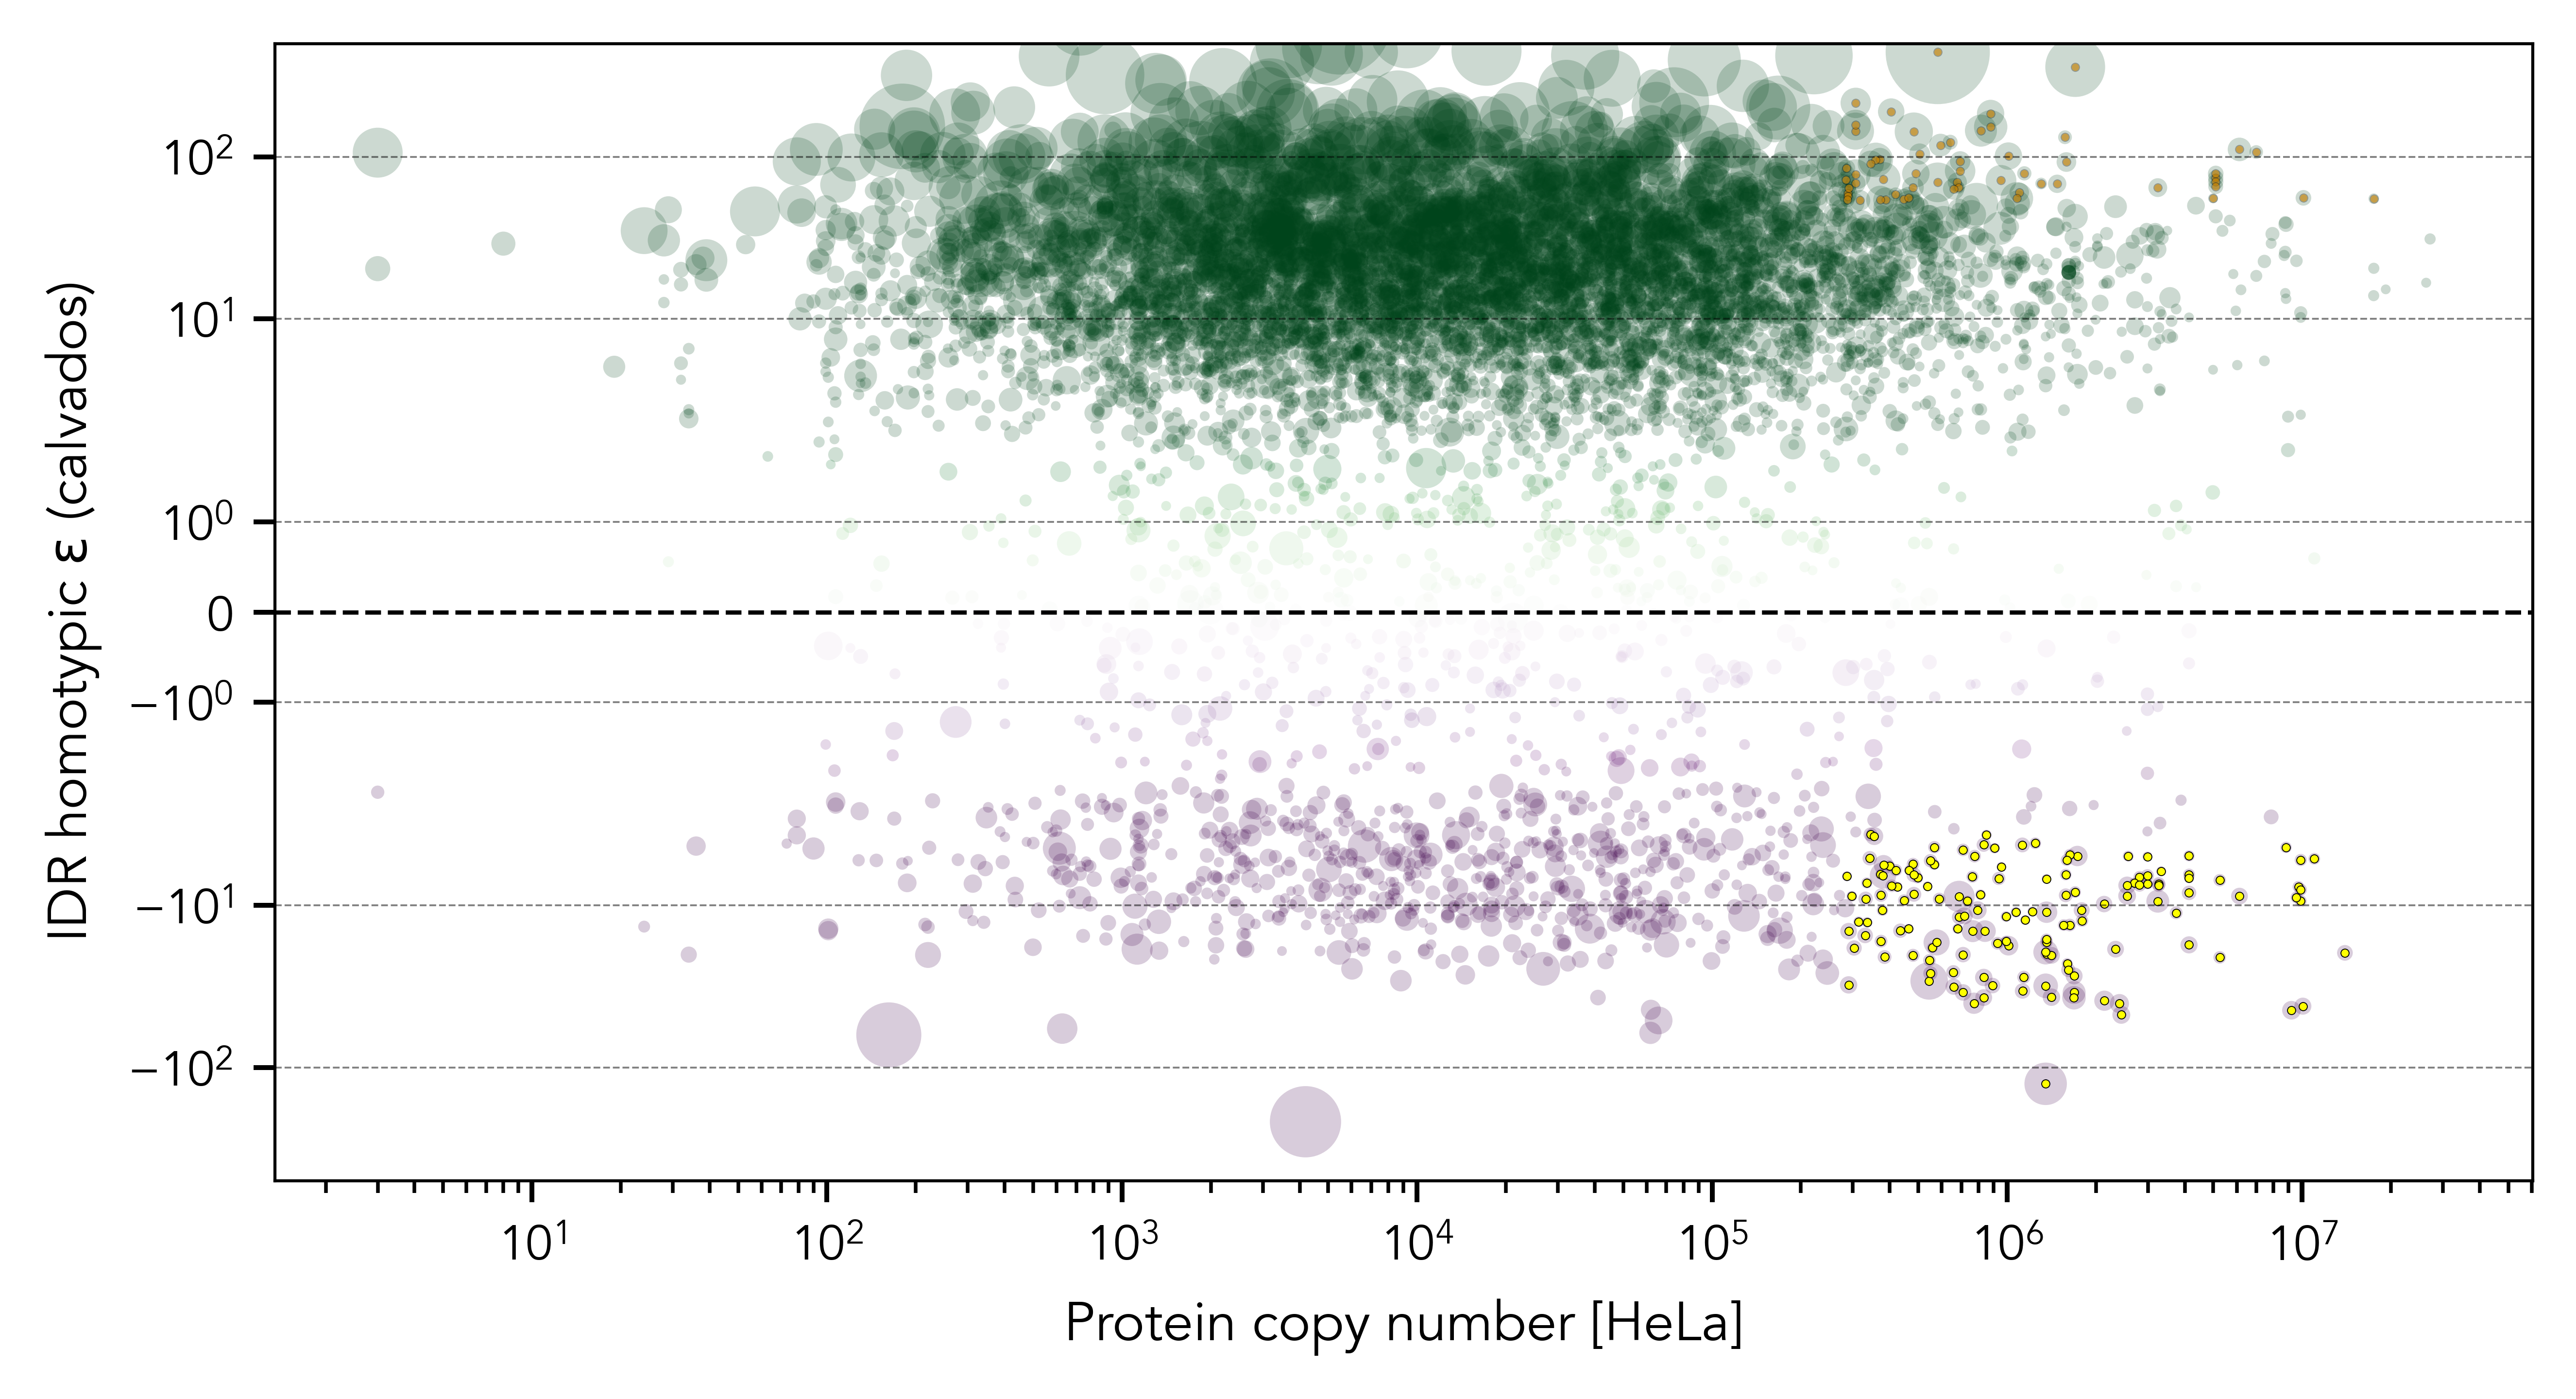

In [14]:
fig = plt.figure(figsize=(6, 3.3), dpi=450)
ax = plt.gca()

high_exp_attractive_eps_uid = []
high_exp_repulsive_eps_uid = []

high_exp_attractive_eps_domains = []
high_exp_repulsive_eps_domains = []

plt.scatter(conc, eps, s=sizes, c=eps, vmin=-2, vmax=2, cmap='PRGn', alpha=0.2, linewidth=0)
for idx in range(len(conc)):
    if conc[idx] > high_copy_thresh and eps[idx] <= eps_attractive_thresh:        
        
        plt.plot(conc[idx], eps[idx], 'o',ms=1.5,mew=0, color='k')
        plt.plot(conc[idx], eps[idx], 'o',ms=1.2,mew=0, color='yellow')

        high_exp_attractive_eps_uid.append(domains[idx].protein.unique_ID)
        high_exp_attractive_eps_domains.append(domains[idx])

for idx in range(len(conc)):
    if conc[idx] > high_copy_thresh and eps[idx] >= eps_repilsive_thresh:        
        
        plt.plot(conc[idx], eps[idx], 'o',ms=1.5,mew=0, color='k', alpha=0.3)
        plt.plot(conc[idx], eps[idx], 'o',ms=1.2,mew=0, color='orange', alpha=0.5)

        high_exp_repulsive_eps_uid.append(domains[idx].protein.unique_ID)
        high_exp_repulsive_eps_domains.append(domains[idx])

plt.xscale('log')
plt.yscale('symlog')
ax.axhline(0,color='k',ls='--', lw=0.7)
ax.axhline(-1,color='k',ls='--', lw=0.3, alpha=0.5)
ax.axhline(-10,color='k',ls='--', lw=0.3, alpha=0.5)
ax.axhline(-100,color='k',ls='--', lw=0.3, alpha=0.5)

ax.axhline(1,color='k',ls='--', lw=0.3, alpha=0.5)
ax.axhline(10,color='k',ls='--', lw=0.3, alpha=0.5)
ax.axhline(100,color='k',ls='--', lw=0.3, alpha=0.5)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Protein copy number [HeLa]', fontsize=9)
plt.ylabel(r'IDR homotypic $\rm \epsilon$' + f" ({mode})", fontsize=9)

plt.ylim([-500,500])
plt.tight_layout()
plt.savefig(f'out_figures/eps_vs_abundance_{mode}.pdf')

In [15]:
with open(f'../../data/outdata/expression_related/highly_expressed_attractive_eps_{mode}.txt', 'w') as fh:
    for k in set(high_exp_attractive_eps_uid):
        fh.write(f'{k}\n')

outdict = {}
for d in high_exp_attractive_eps_domains:
    n = d.protein.name + f" PROTEIN_COPYNUMBER={d.protein.attribute('copy_number')}  IDR_EPSILON={d.attribute('eps')} IDR_BOUNDARIES= START={d.start} END={d.end} "
    outdict[n] = d.sequence

protfasta.write_fasta(outdict, f'../../data/outdata/expression_related/highly_expressed_attractive_eps_{mode}.fasta')
    

In [16]:
with open(f'../../data/outdata/expression_related/highly_expressed_repulsive_eps_{mode}.txt', 'w') as fh:
    for k in set(high_exp_repulsive_eps_uid):
        fh.write(f'{k}\n')

outdict = {}
for d in high_exp_repulsive_eps_domains:
    n = d.protein.name + f" PROTEIN_COPYNUMBER={d.protein.attribute('copy_number')}  IDR_EPSILON={d.attribute('eps')} IDR_BOUNDARIES= START={d.start} END={d.end} "
    outdict[n] = d.sequence

protfasta.write_fasta(outdict, f'../../data/outdata/expression_related/highly_expressed_repulsive_eps_{mode}.fasta')